# SOCIAL MEDIA ANALYSIS: VISUAL SENTIMENT ANALYSIS
#### TEAM NAME: PHOENIX
#### TEAM MEMBERS: NAGA CHARITHA SADINENI, MAHIMA SANTOSHI, VENKATA SRI ATHULYA GOPISHETTY, KEERTHANA GUDAPATI
#### MODEL IMPLEMENTED: RESNET50

In [1]:
# IMPORTING LIBRARIES

import matplotlib.image as img
import tensorflow.keras as keras
import numpy as np
import pandas as pd
from keras.utils import plot_model
%matplotlib inline
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
#LOADING DATASET INTO DATAFRAME

df = pd.read_csv("t4sa_data.csv")
df.head()

Image url Sentiment
0  train_images/769272729082138624-1.jpg   Neutral
1  train_images/783998473246871552-3.jpg  Positive
2  train_images/783802817320325120-3.jpg   Neutral
3  train_images/782816296073396224-1.jpg   Neutral
4  train_images/769243645740457984-1.jpg   Neutral

#### SPLITTING DATASET INTO TRAINING, VALIDATION, AND TESTING

In [3]:
#TRAINING DATASET

train_val = int(0.8*len(df))
train = df[:train_val]
train.head()

Image url Sentiment
0  train_images/769272729082138624-1.jpg   Neutral
1  train_images/783998473246871552-3.jpg  Positive
2  train_images/783802817320325120-3.jpg   Neutral
3  train_images/782816296073396224-1.jpg   Neutral
4  train_images/769243645740457984-1.jpg   Neutral

In [4]:
#VALIDATION DATASET

testval = df[train_val:]
test_val = int(0.5*len(testval))
validation = testval[:test_val]
test = testval[test_val:]
validation.head()

Image url Sentiment
24000  train_images/769008177543340032-1.jpg  Positive
24001  train_images/768843995694923776-1.jpg  Positive
24002  train_images/781909999245144064-3.jpg   Neutral
24003  train_images/801699706971688960-1.jpg  Negative
24004  train_images/795600589191192576-1.jpg  Negative

In [5]:
#TEST DATASET

test.head()

Image url Sentiment
27000  train_images/769450118764429312-1.jpg   Neutral
27001  train_images/769197625853743104-1.jpg  Positive
27002  train_images/795984577705680896-1.jpg  Negative
27003  train_images/803221664716746752-4.jpg  Negative
27004  train_images/784327642187042816-1.jpg  Positive

#### PREPROCESSING TRAINING, VALIDATION, AND TESTING DATA

In [6]:
#IMAGE PREPROCESSING

from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 30

def generators(shape, preprocessing): 
    '''Create the training and validation datasets for 
    a given image shape.
    '''
    imgdatagen = ImageDataGenerator(
        preprocessing_function = preprocessing,
        horizontal_flip = True, 
        validation_split = 0.1,
    )
    
    height, width = shape
    
    
    train_generator = imgdatagen.flow_from_dataframe(
                                        dataframe = train, 
                                        directory="",
                                        x_col="Image url",
                                        y_col="Sentiment",
                                        class_mode="categorical",
                                        target_size=(height, width),
                                        batch_size=batch_size)
    
    val_generator = imgdatagen.flow_from_dataframe(
                                        dataframe = validation, 
                                        directory="",
                                        x_col="Image url",
                                        y_col="Sentiment",
                                        class_mode="categorical",
                                        target_size=(height, width),
                                        batch_size=batch_size)
    
    test_generator = imgdatagen.flow_from_dataframe(
                                        dataframe = test, 
                                        directory="",
                                        x_col="Image url",
                                        y_col="Sentiment",
                                        class_mode="categorical",
                                        target_size=(height, width),
                                        batch_size=batch_size)
    return train_generator, val_generator, test_generator

#### MODEL IMPLEMENTATION

In [8]:
#LOADING RESNET50 MODEL

resnet50 = keras.applications.resnet50
train_generator, val_generator, test_generator = generators((224,224), preprocessing=resnet50.preprocess_input)

Found 24000 validated image filenames belonging to 3 classes.
Found 3000 validated image filenames belonging to 3 classes.
Found 3000 validated image filenames belonging to 3 classes.


In [9]:
conv_model = resnet50.ResNet50(weights = 'imagenet', include_top=False, input_shape=(224,224,3))
for layer in conv_model.layers[:-26]:
    layer.trainable = False
x = keras.layers.Flatten()(conv_model.output)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(100, activation='relu')(x)
predictions = keras.layers.Dense(3, activation='softmax')(x)
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [15]:
#MODEL COMPILATION

full_model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adamax(lr=1e-05),
                  metrics=['acc'])
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
callback_list = []
callback_list.append(EarlyStopping(monitor='val_loss', patience=1))

In [16]:
#MODEL TRAINING

history = full_model.fit_generator(
    train_generator, 
    validation_data = val_generator,
    workers=10,
    epochs=20,
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
800/800 [==============================] - 3485s 4s/step - loss: 1.2613 - acc: 0.3467 - val_loss: 1.1004 - val_acc: 0.3790
Epoch 2/20
800/800 [==============================] - 9506s 12s/step - loss: 1.1280 - acc: 0.3722 - val_loss: 1.0887 - val_acc: 0.3857
Epoch 3/20
800/800 [==============================] - 3373s 4s/step - loss: 1.0911 - acc: 0.3960 - val_loss: 1.0781 - val_acc: 0.4113
Epoch 4/20
800/800 [==============================] - 3395s 4s/step - loss: 1.0670 - acc: 0.4211 - val_loss: 1.0758 - val_acc: 0.4033
Epoch 5/20
800/800 [==============================] - 3394s 4s/step - loss: 1.0467 - acc: 0.4398 - val_loss: 1.0735 - val_acc: 0.4197
Epoch 6/20
800/800 [==============================] - 3389s 4s/step - loss: 1.0259 - acc: 0.4651 - val_loss: 1.0735 - val_acc: 0.4237
Epoch 7/20
800/800 [==============================] - 3376s 4s/step - loss: 1.0051 - acc: 0.4844 - val_loss: 1.0770 - v

In [65]:
#SAVING MODEL WEIGHTS

full_model.save_weights('resnet50.h5')

In [66]:
#SAVING MODEL

full_model.save('resnet.h5')

#### GRAPHS

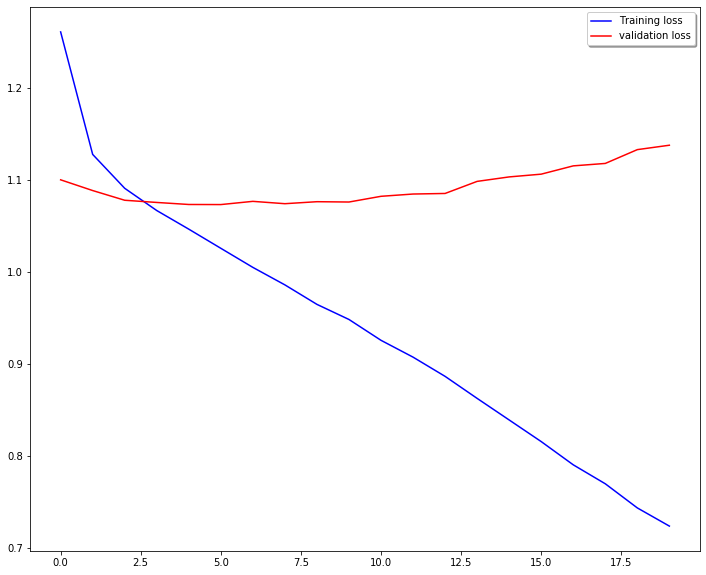

In [20]:
#GRAPH FOR TRAINING AND VALIDATION LOSS

fig = plt.subplots(figsize=(12,10))
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss")
plt.legend(loc='best', shadow=True)

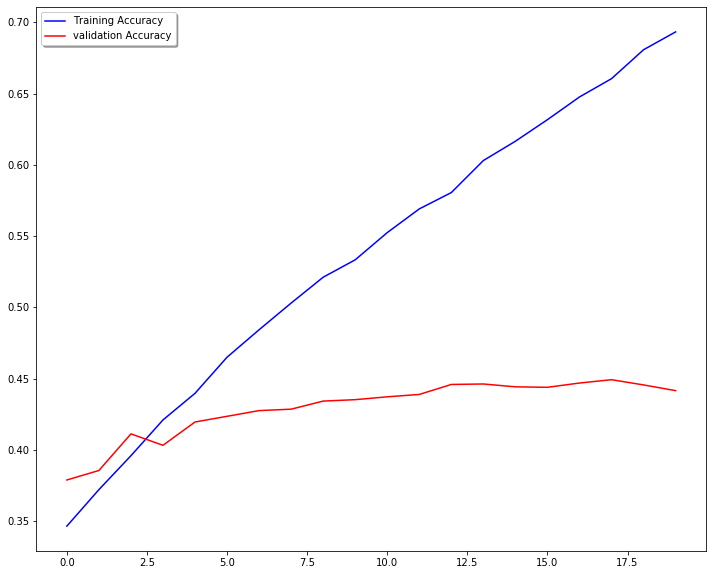

In [21]:
#GRAPH FOR TRAINING AND VALIDATION ACCURACY

fig = plt.subplots(figsize=(12,10))
plt.plot(history.history['acc'], color='b', label="Training Accuracy")
plt.plot(history.history['val_acc'], color='r', label="validation Accuracy")
plt.legend(loc='best', shadow=True)

2


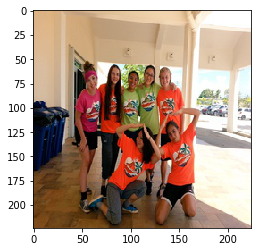

In [24]:
from keras.preprocessing import image
img_path = 'train_images/783998473246871552-3.jpg'
img = image.load_img(path=img_path, target_size=(224,224,3))
img = image.img_to_array(img)
test_img = img.reshape((1,224,224,3))
img_class = full_model.predict(test_img)
for n in img_class:
    prediction = np.argmax(n)
    print(prediction)
plt.imshow(img.astype('int'))

#### MODEL PREDICTION

In [25]:
#EVALUATING TRAINING DATA

import sys
def true_and_predicted_labels(dataset):
    labels = np.zeros((dataset.n,3))
    preds = np.zeros_like(labels)
    for i in range(len(dataset)):
        sys.stdout.write('evaluating batch {}\r'.format(i))
        sys.stdout.flush()
        batch = dataset[i]
        batch_images = batch[0]
        batch_labels = batch[1]
        batch_preds = full_model.predict(batch_images)
        start = i*batch_size
        labels[start:start+batch_size] = batch_labels
        preds[start:start+batch_size] = batch_preds
    return labels, preds

train_labels, train_preds = true_and_predicted_labels(train_generator)

In [26]:
#PREDICTIONS ON TRAINING DATA

def predicted_labels(preds):
    for y in preds:
        maximum = np.max(y)
        y[np.where(y==maximum)] = 1
        high = np.max(y)
        y[np.where(y!=high)] = 0
    return preds

train_pred_labels = predicted_labels(train_preds)
print('predicted labels:')
print(train_pred_labels)
print('true labels:')
print(train_labels)

predicted labels:
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
true labels:
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [27]:
#EVALUATING VALIDATION DATA

val_labels, val_preds = true_and_predicted_labels(val_generator)

In [28]:
#PREDICTIONS ON VALIDATION DATA

val_pred_labels = predicted_labels(val_preds)
print('predicted labels:')
print(val_pred_labels)
print('true labels:')
print(val_labels)

predicted labels:
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
true labels:
[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [30]:
val_nm_labels=[]
for y in val_pred_labels:
    if(y[-3]==1):
        val_nm_labels.append('Negative')
    elif(y[-2]==1):
        val_nm_labels.append('Neutral')
    else:
        val_nm_labels.append('Positive')

In [31]:
df = pd.DataFrame(val_nm_labels)
df.columns = ['Prediction']
df

Prediction
0      Positive
1      Positive
2       Neutral
3      Negative
4      Negative
...         ...
2995    Neutral
2996   Positive
2997   Positive
2998   Negative
2999    Neutral

[3000 rows x 1 columns]

In [32]:
df.reset_index(drop=True, inplace=True)
validation.reset_index(drop=True, inplace=True)

In [33]:
valid_df = pd.concat( [validation, df], axis=1) 
valid_df

Image url Sentiment Prediction
0     train_images/769008177543340032-1.jpg  Positive   Positive
1     train_images/768843995694923776-1.jpg  Positive   Positive
2     train_images/781909999245144064-3.jpg   Neutral    Neutral
3     train_images/801699706971688960-1.jpg  Negative   Negative
4     train_images/795600589191192576-1.jpg  Negative   Negative
...                                     ...       ...        ...
2995  train_images/768993182910713857-1.jpg  Positive    Neutral
2996  train_images/781567165220741120-1.jpg  Positive   Positive
2997  train_images/769258233555025920-1.jpg  Positive   Positive
2998  train_images/803659629758742528-1.jpg  Negative   Negative
2999  train_images/781450873943666688-1.jpg   Neutral    Neutral

[3000 rows x 3 columns]

In [34]:
#MISCLASSIFIED VALIDATION DATA

val_misclassified = []
pos_val_misclassified = []
neg_val_misclassified = []
neu_val_misclassified = []
valid_df['misclassified']=(valid_df[['Sentiment']].values != valid_df[['Prediction']].values).all(axis=1).astype(int)
val_misclassified=valid_df.loc[valid_df['misclassified']!=0] 
pos_val_misclassified = val_misclassified.loc[val_misclassified['Sentiment']== 'Positive']
neg_val_misclassified = val_misclassified.loc[val_misclassified['Sentiment']== 'Negative']
neu_val_misclassified = val_misclassified.loc[val_misclassified['Sentiment']== 'Neutral']

In [35]:
pos_val_misclassified = pos_val_misclassified['Image url']
neg_val_misclassified = neg_val_misclassified['Image url']
neu_val_misclassified = neu_val_misclassified['Image url']

In [36]:
def plot_images(imgs, i):
    ncols, nrows = (5, 2) 
    start = i*ncols*nrows
    fig = plt.figure( figsize=(ncols*5, nrows*5), dpi=50)
    for i, img in enumerate(imgs[start:start+ncols*nrows]):
        plt.subplot(nrows, ncols, i+1)
        img = plt.imread(img)
        plt.imshow(img)
        plt.axis('off')

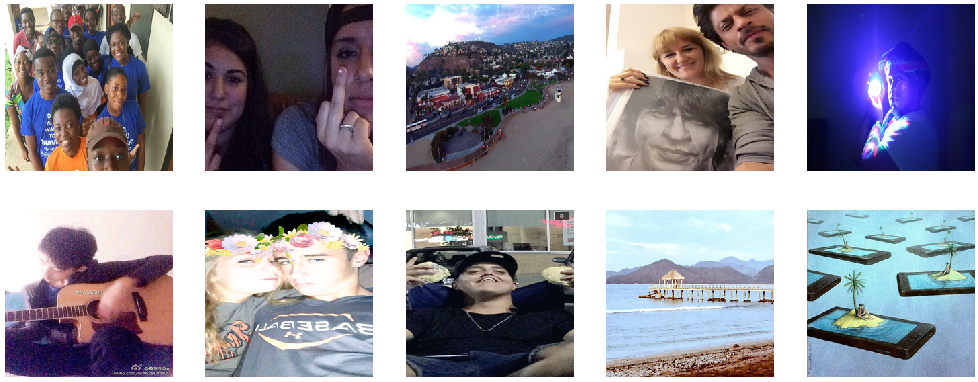

In [37]:
#MISCLASSIFIED POSITIVE IMAGES

plot_images(pos_val_misclassified,0)

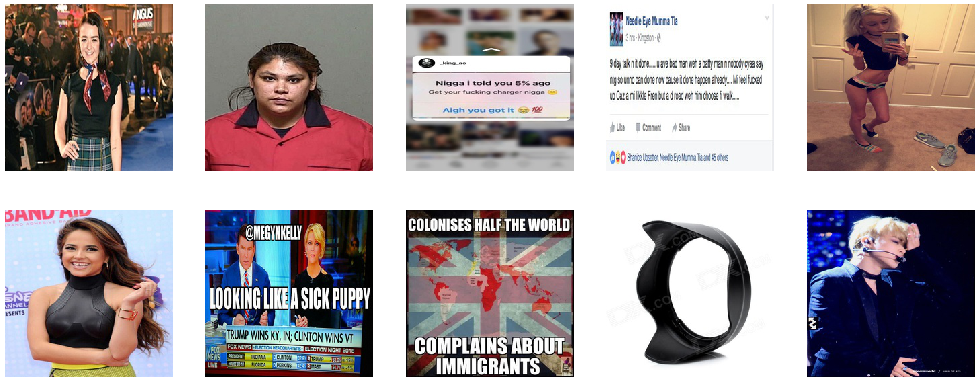

In [38]:
#MISCLASSIFIED NEGATIVE IMAGES

plot_images(neg_val_misclassified,0)

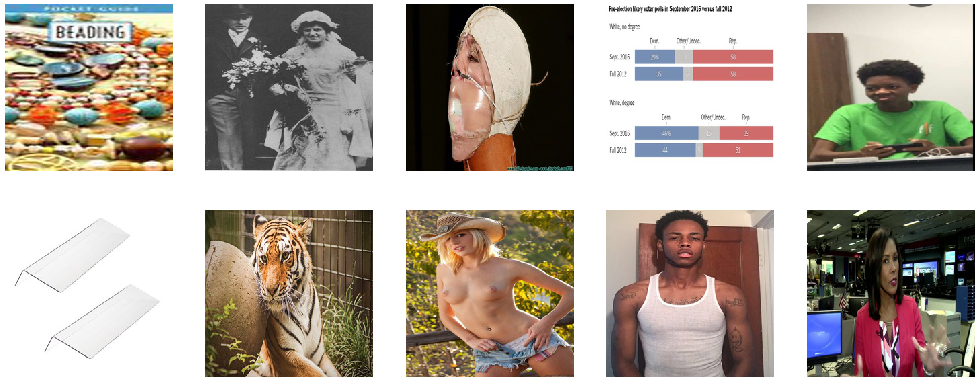

In [39]:
#MISCLASSIFIED NEUTRAL IMAGES

plot_images(neu_val_misclassified,0)

In [40]:
#CLASSIFICATION REPORT FOR VALIDATION DATA

from sklearn.metrics import classification_report
target_names = ['Negative', 'Neutral', 'Positive']
print(classification_report(val_preds, val_labels, target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.57      0.43      0.49      1320
     Neutral       0.50      0.46      0.48      1106
    Positive       0.27      0.47      0.34       574

   micro avg       0.45      0.45      0.45      3000
   macro avg       0.45      0.45      0.44      3000
weighted avg       0.49      0.45      0.46      3000
 samples avg       0.45      0.45      0.45      3000



In [107]:
#EVALUATING TEST DATA

test_labels, test_preds = true_and_predicted_labels(test_generator)

In [108]:
#PREDICTIONS ON TEST DATA

test_pred_labels = predicted_labels(test_preds)
print('predicted labels:')
print(test_pred_labels)
print('true labels:')
print(test_labels)

predicted labels:
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
true labels:
[[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [109]:
test_nm_labels=[]
for y in test_pred_labels:
    if(y[-3]==1):
        test_nm_labels.append('Negative')
    elif(y[-2]==1):
        test_nm_labels.append('Neutral')
    else:
        test_nm_labels.append('Positive')

In [110]:
df1 = pd.DataFrame(test_nm_labels)
df1.columns = ['Prediction']
df1

Prediction
0       Neutral
1       Neutral
2       Neutral
3      Positive
4       Neutral
...         ...
2995   Negative
2996   Positive
2997   Negative
2998    Neutral
2999   Negative

[3000 rows x 1 columns]

In [111]:
df1.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [112]:
test_df = pd.concat( [test, df1], axis=1) 
test_df

Image url Sentiment Prediction
0     train_images/769450118764429312-1.jpg   Neutral    Neutral
1     train_images/769197625853743104-1.jpg  Positive    Neutral
2     train_images/795984577705680896-1.jpg  Negative    Neutral
3     train_images/803221664716746752-4.jpg  Negative   Positive
4     train_images/784327642187042816-1.jpg  Positive    Neutral
...                                     ...       ...        ...
2995  train_images/783667760731529216-1.jpg  Negative   Negative
2996  train_images/796387373487718400-2.jpg  Negative   Positive
2997  train_images/798656055760650241-1.jpg  Negative   Negative
2998  train_images/780919157856403457-1.jpg  Positive    Neutral
2999  train_images/784319861753155584-1.jpg   Neutral   Negative

[3000 rows x 3 columns]

In [113]:
#MISCLASSIFIED TEST DATA

test_misclassified = []
pos_test_misclassified = []
neg_test_misclassified = []
neu_test_misclassified = []
test_df['misclassified']=(test_df[['Sentiment']].values != test_df[['Prediction']].values).all(axis=1).astype(int)
test_misclassified=test_df.loc[test_df['misclassified']!=0] 
pos_test_misclassified = test_misclassified.loc[test_misclassified['Sentiment']== 'Positive']
neg_test_misclassified = test_misclassified.loc[test_misclassified['Sentiment']== 'Negative']
neu_test_misclassified = test_misclassified.loc[test_misclassified['Sentiment']== 'Neutral']

In [114]:
pos_test_misclassified = pos_test_misclassified['Image url']
neg_test_misclassified = neg_test_misclassified['Image url']
neu_test_misclassified = neu_test_misclassified['Image url']

In [115]:
def plot_images(imgs, i):
    ncols, nrows = (5, 2) 
    start = i*ncols*nrows
    fig = plt.figure( figsize=(ncols*5, nrows*5), dpi=50)
    for i, img in enumerate(imgs[start:start+ncols*nrows]):
        plt.subplot(nrows, ncols, i+1)
        img = plt.imread(img)
        plt.imshow(img)
        plt.axis('off')

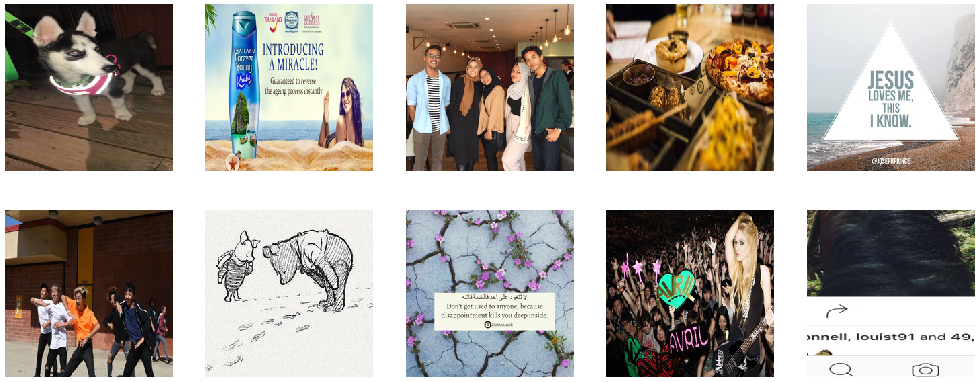

In [116]:
#MISCLASSIFIED POSITIVE IMAGES

plot_images(pos_test_misclassified,0)

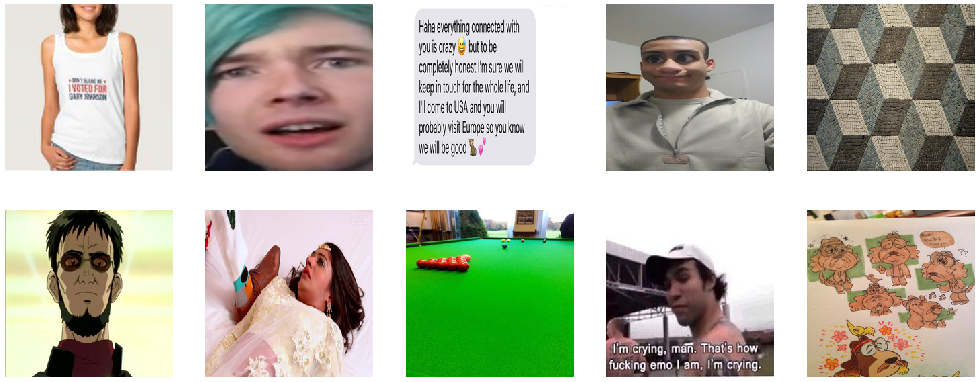

In [117]:
#MISCLASSIFIED NEGATIVE IMAGES

plot_images(neg_test_misclassified,0)

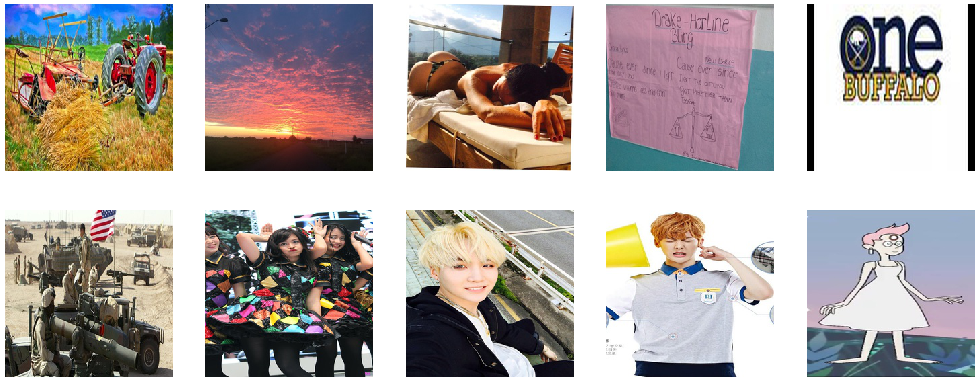

In [118]:
#MISCLASSIFIED NEUTRAL IMAGES

plot_images(neu_test_misclassified,0)

In [119]:
#CLASSIFICATION REPORT FOR TEST DATA

from sklearn.metrics import classification_report
target_names = ['Negative', 'Neutral', 'Positive']
print(classification_report(test_preds, test_labels, target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.57      0.45      0.50      1251
     Neutral       0.52      0.46      0.49      1135
    Positive       0.32      0.52      0.39       614

   micro avg       0.47      0.47      0.47      3000
   macro avg       0.47      0.47      0.46      3000
weighted avg       0.50      0.47      0.47      3000
 samples avg       0.47      0.47      0.47      3000



In [120]:
#ACCURACY OF MODEL ON TEST DATA

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_pred_labels, test_labels)
print(accuracy)

0.466


In [121]:
#CORRECTLY CLASSIFIED TEST DATA

test_classified = []
pos_test_classified = []
neg_test_classified = []
neu_test_classified = []
test_df['classified']=(test_df[['Sentiment']].values == test_df[['Prediction']].values).all(axis=1).astype(int)
test_classified=test_df.loc[test_df['classified']!=0] 
pos_test_classified = test_classified.loc[test_classified['Sentiment']== 'Positive']
neg_test_classified = test_classified.loc[test_classified['Sentiment']== 'Negative']
neu_test_classified = test_classified.loc[test_classified['Sentiment']== 'Neutral']

In [122]:
pos_test_classified = pos_test_classified['Image url']
neg_test_classified = neg_test_classified['Image url']
neu_test_classified = neu_test_classified['Image url']

In [128]:
def plot_images(imgs, i):
    ncols, nrows = (4, 2) 
    start = i*ncols*nrows
    fig = plt.figure( figsize=(ncols*5, nrows*5), dpi=50)
    for i, img in enumerate(imgs[start:start+ncols*nrows]):
        plt.subplot(nrows, ncols, i+1)
        img = plt.imread(img)
        plt.imshow(img)
        plt.axis('off')

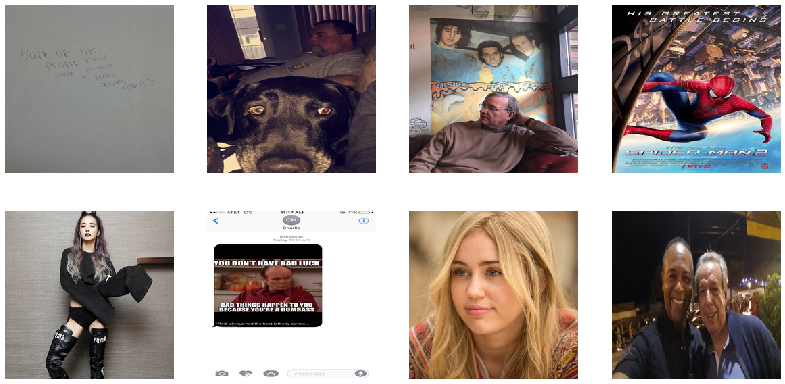

In [129]:
#CORRECTLY CLASSIFIED POSITIVE IMAGES

plot_images(pos_test_classified,0)

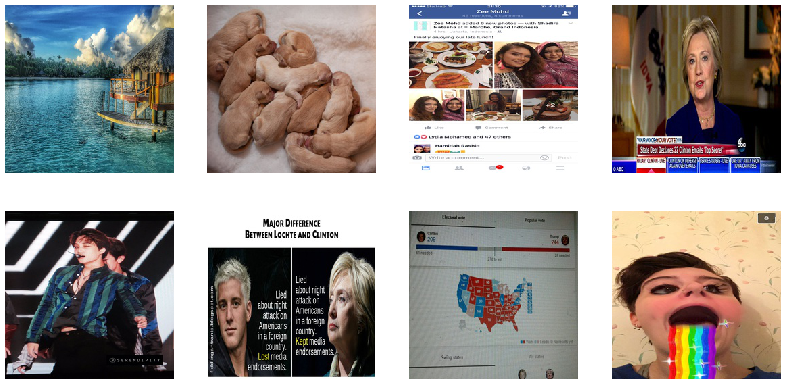

In [130]:
#CORRECTLY CLASSIFIED NEGATIVE IMAGES

plot_images(neg_test_classified,0)

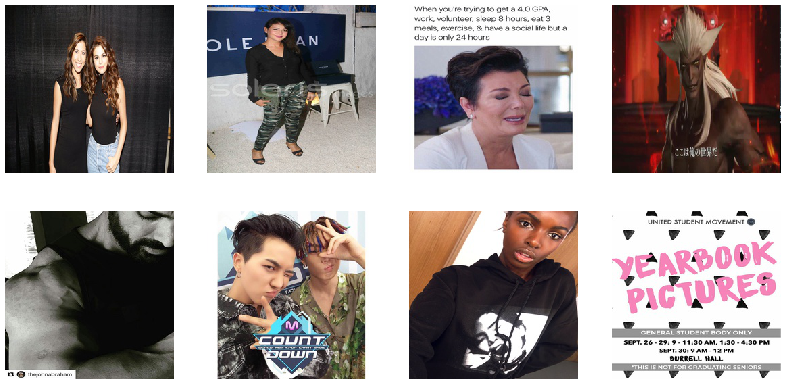

In [131]:
#CORRECTLY CLASSIFIED NEUTRAL IMAGES

plot_images(neu_test_classified,0)